# **Import needed libraries**

In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# **Import Dataset**

In [152]:
df = pd.read_csv(filepath_or_buffer='Phishing_Legitimate_full.csv', header=0)
len(df)

10000

**Get technical information of dataset**

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 

Data preparation
- Get Top-Level-Domain
- Get Length of Domain
- Get Amount Characters of Domain
- Get Amount of Numbers of Domain
- Get Amount of special characters of Domain
- Get IP-Address
- Get External Score
- Get Length of URL
- Get Amount of .
- Get Amount of /
- Get Amount Characters of URL
- Get Amount of Numbers of URL
- Get Amount of special characters of URL
- Get if a IP-Address is included in the URL
- Get Amount of Subdomains
- Get Length of Subdomain-Part
- Get Amount of directories
- Get Length of directory-part
- Get if URL was shortened
- Get if URL redirects
- Get Buzzwords in URL -> create Wordcloud

**Add the URL to the corresponding entries**

In [154]:
url_column = []

phishing_file = open("url_list_phishing_5000.txt", "r")
for line in phishing_file:
    url_column.append(line)

legitimate_file = open("url_list_legitimate_5000.txt", "r")
for line in legitimate_file:
    url_column.append(line)

df['URL'] = url_column

len(url_column)

10000

In [155]:
df.head(5)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL,URL
0,1,3,1,5,72,0,0,0,0,0,...,0,1,1,0,1,1,-1,1,1,http://promomultiplus.hol.es/multiplus/super/t...
1,2,3,1,3,144,0,0,0,0,2,...,0,0,1,-1,1,1,1,1,1,http://www.electromed.cl/suc/1/login.php?actio...
2,3,3,1,2,58,0,0,0,0,0,...,0,0,1,0,-1,1,-1,0,1,http://www.protackleoutfitters.com/xristianmin...
3,4,3,1,6,79,1,0,0,0,0,...,0,0,1,-1,1,1,1,-1,1,http://www.blossomluxuria.com/wp-content/theme...
4,5,3,0,4,46,0,0,0,0,0,...,0,0,1,1,-1,0,-1,-1,1,http://ciasww.com/love/me/a/access89.oroki.php\n


**Check which URLs are still working**

**Delete all rows that contain IP-addresses from main dataframe and consider them separatly**

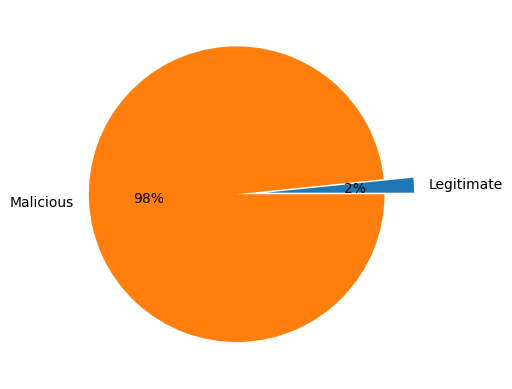

In [156]:
ip_regex = re.compile(r'\b(?:\d{1,3}\.){3}\d{1,3}\b')

df_ip = df.loc[df['URL'].str.contains(ip_regex, regex=True)]
df_ip_groupBy_label = df_ip.groupby(by=['CLASS_LABEL'],as_index = False).count()
amount_ip_addresses = df_ip_groupBy_label['URL'].sum()
df_ip_groupBy_label['Percentage'] = (df_ip_groupBy_label['URL'] / amount_ip_addresses) * 100

mylabels = ["Legitimate", "Malicious"]
myexplode = [0.2, 0]

plt.pie(df_ip_groupBy_label['URL'], labels = mylabels, explode = myexplode, autopct=lambda p: '{:.0f}%'.format(p))
plt.show() 

The numbers show, that if a URL is including an IP-address it is very likely that the URL is malicious. Within the dataset 99,67% of all URLs that include an IP-address are malicious.

**General Distribution of Bad vs Good URLs**

In [157]:
df_groupBy_label = df.groupby(by=['CLASS_LABEL'],as_index = False).count()
df_groupBy_label.head(10)

,CLASS_LABEL,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,URL
0,0,5000,5000,5000,5000,5000,5000,5000,5000,5000,...,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000
1,1,5000,5000,5000,5000,5000,5000,5000,5000,5000,...,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000


**Get Domain of every URL**

In [158]:
new_column = []    
for values in df['URL']:
    new_column.append(re.search(r'^((http|https)://)?[^(/|\s|:]*', values).group())

df['domain'] = new_column

**Get TLD of every URL -> if not possible to allocate delete the row**

In [159]:
new_column = []    
i = 1
for values in df['domain']:
    try:
        new_column.append(re.search(r'(?<=\.)[a-z]+(?=\/|$)', values).group())
    except:
        new_column.append("n/a")

df['tld'] = new_column

In [160]:
#Delete rows where a TLD cannot be calculated
#na_rows = df.loc[df['tld'] == 'n/a']
#df = df.drop(na_rows.index)

In [161]:
df_tld = df
df_tld['tld_count'] = df_tld['tld']
df_tld_groupBy_label_tld = df_tld.groupby(by=['tld', 'CLASS_LABEL'],as_index = False).count()
amount_tld = df_tld_groupBy_label_tld['tld_count'].sum()
df_tld_pivot_label_tld = df_tld_groupBy_label_tld.pivot_table('tld_count', ['tld'], 'CLASS_LABEL')
df_tld_pivot_label_tld[0] = df_tld_pivot_label_tld[0].fillna(0)
df_tld_pivot_label_tld[1] = df_tld_pivot_label_tld[1].fillna(0)
df_tld_pivot_label_tld['bad_percentage'] = (df_tld_pivot_label_tld[1] / (df_tld_pivot_label_tld[1] + df_tld_pivot_label_tld[0])) * 100
df_tld_pivot_label_tld['overall_percentage'] = ((df_tld_pivot_label_tld[1] + df_tld_pivot_label_tld[0]) / amount_tld ) * 100

df_tld_pivot_label_tld = df_tld_pivot_label_tld.sort_values(by='overall_percentage', ascending=False)

df_tld_pivot_label_tld.head(20)

CLASS_LABEL,0,1,bad_percentage,overall_percentage
tld,,,,
com,3115.0,2418.0,43.701428,55.33
org,588.0,230.0,28.117359,8.18
net,250.0,144.0,36.548223,3.94
br,33.0,257.0,88.620690,2.90
edu,239.0,0.0,0.000000,2.39
au,34.0,161.0,82.564103,1.95
uk,90.0,92.0,50.549451,1.82
n/a,0.0,172.0,100.000000,1.72
de,64.0,71.0,52.592593,1.35


Some TLDs do have a high percentage of bad urls in comparison to others -> reasons for that could be costs of tlds -> further investigation for the top 20 tlds used -> comparison of prices hard

In [162]:
df.head(15)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL,URL,domain,tld,tld_count
0,1,3,1,5,72,0,0,0,0,0,...,0,1,1,-1,1,1,http://promomultiplus.hol.es/multiplus/super/t...,http://promomultiplus.hol.es,es,es
1,2,3,1,3,144,0,0,0,0,2,...,-1,1,1,1,1,1,http://www.electromed.cl/suc/1/login.php?actio...,http://www.electromed.cl,cl,cl
2,3,3,1,2,58,0,0,0,0,0,...,0,-1,1,-1,0,1,http://www.protackleoutfitters.com/xristianmin...,http://www.protackleoutfitters.com,com,com
3,4,3,1,6,79,1,0,0,0,0,...,-1,1,1,1,-1,1,http://www.blossomluxuria.com/wp-content/theme...,http://www.blossomluxuria.com,com,com
4,5,3,0,4,46,0,0,0,0,0,...,1,-1,0,-1,-1,1,http://ciasww.com/love/me/a/access89.oroki.php\n,http://ciasww.com,com,com
5,6,3,1,1,42,1,0,0,0,0,...,1,1,1,-1,1,1,http://formulario.chatnook.com/lang-uk.php\n,http://formulario.chatnook.com,com,com
6,7,2,0,5,60,0,0,0,0,0,...,0,1,1,-1,-1,1,http://bomnuoctoanluc.vn/img/common/common2/ya...,http://bomnuoctoanluc.vn,vn,vn
7,8,1,0,3,30,0,0,0,0,0,...,1,1,1,1,1,1,http://impromin.com/db105/box/\n,http://impromin.com,com,com
8,9,8,7,2,76,1,1,0,0,0,...,-1,1,1,1,-1,1,http://easyweb33.tdcanada.de.veronica.porto-do...,http://easyweb33.tdcanada.de.veronica.porto-do...,com,com
9,10,2,0,2,46,0,0,0,0,0,...,1,1,1,-1,-1,1,http://iisolutions.md/media/alibabaproduct.htm\n,http://iisolutions.md,md,md


In [163]:
df_describe = df.groupby('CLASS_LABEL').describe().transpose()

C:\Users\fhupe\AppData\Local\Temp\ipykernel_32372\600777326.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), vmax = 1, linewidths = 0.5, fmt= '.1f',


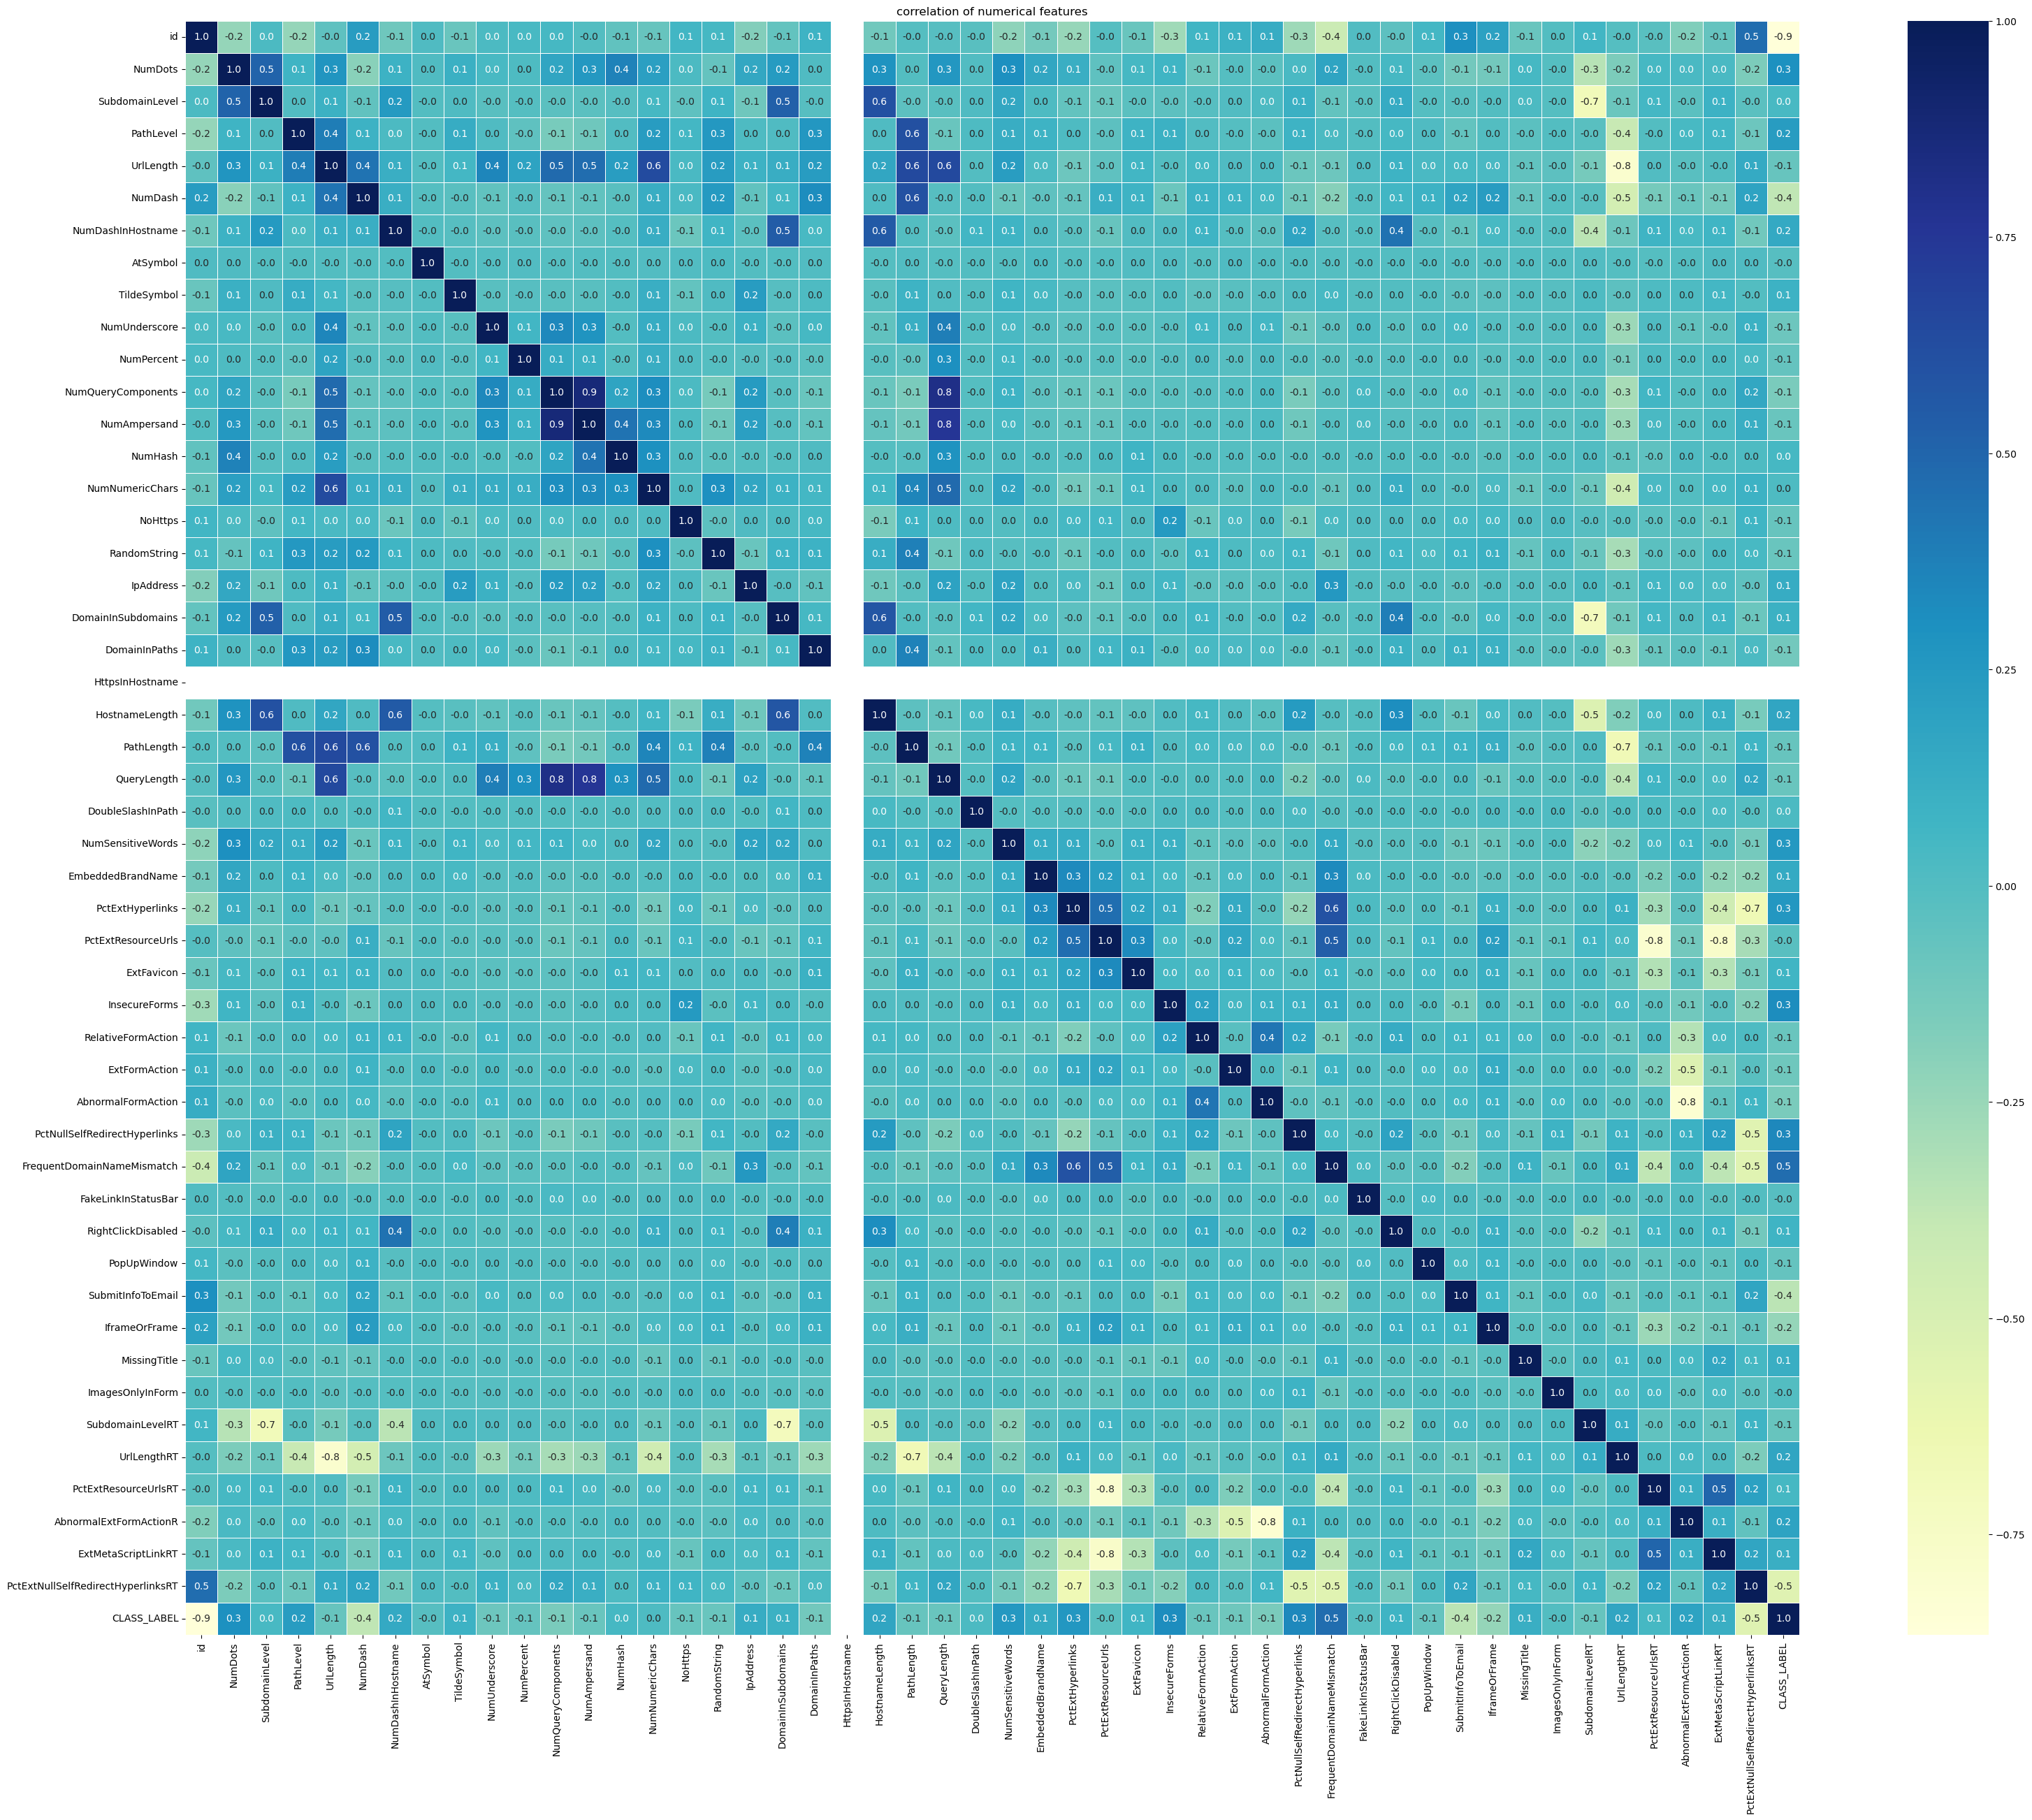

In [164]:
plt.figure(figsize = (40, 30))
sns.heatmap(df.corr(), vmax = 1, linewidths = 0.5, fmt= '.1f',
            square = True, annot = True, cmap = 'YlGnBu', linecolor = "white")
plt.title('correlation of numerical features');

**WordCloud**

In [165]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [166]:
df['text_tokenized'] = df.URL.map(lambda t: tokenizer.tokenize(t))

In [167]:
stemmer = SnowballStemmer("english")

In [168]:
df['text_stemmed'] = df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])

In [169]:
df['text_sent'] = df['text_stemmed'].map(lambda l: ' '.join(l))

In [170]:
df_phishing = df[df.CLASS_LABEL == 1]
df_legitimate = df[df.CLASS_LABEL == 0]

In [171]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(8.0,6.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http','https','org','net','br','edu'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

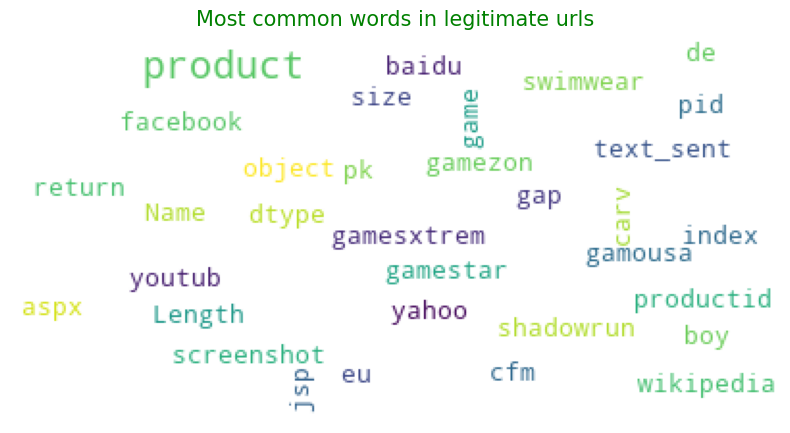

In [172]:
data = df_legitimate.text_sent
data.reset_index(drop=True, inplace=True)
common_text = str(data)
plot_wordcloud(common_text, None, max_words=400, max_font_size=20, 
               title = 'Most common words in legitimate urls', title_size=15)

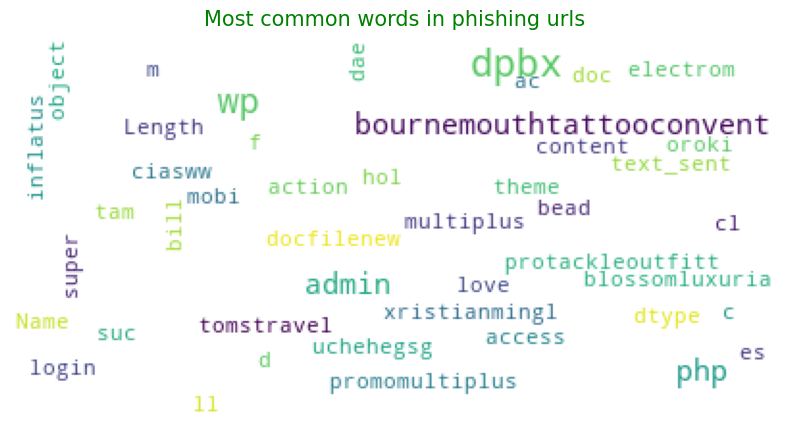

In [173]:
data = df_phishing.text_sent
data.reset_index(drop=True, inplace=True)
common_text = str(data)
plot_wordcloud(common_text, None, max_words=400, max_font_size=20, 
               title = 'Most common words in phishing urls', title_size=15)

In [174]:
df.sample()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL,URL,domain,tld,tld_count,text_tokenized,text_stemmed,text_sent
9268,9269,2,1,3,50,1,0,0,0,0,...,0,1,0,http://www.animationmagazine.net/tag/frank-agr...,http://www.animationmagazine.net,net,net,"[http, www, animationmagazine, net, tag, frank...","[http, www, animationmagazin, net, tag, frank,...",http www animationmagazin net tag frank agrama


**Preprocessing for machine learning**

In [175]:
from sklearn.model_selection import train_test_split

df = df.drop(['URL', 'domain', 'tld_count', 'text_tokenized', 'text_stemmed', 'text_sent', 'id'], axis=1)

# Move 'CLASS_LABEL' to the last position
class_label = df.pop('CLASS_LABEL')
df['CLASS_LABEL'] = class_label

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['CLASS_LABEL'])

In [176]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

cols = df.columns[df.dtypes.eq('object')]

for col in cols:
    df_test[col] = le.fit_transform(df_test[col])
    df_train[col] = le.fit_transform(df_train[col])

In [177]:
# train-data
y_train = np.asarray(df_train.loc[:, 'CLASS_LABEL'])
X_train = np.asarray(df_train.iloc[:, :-1])

# test-data
y_test = np.asarray(df_test.loc[:, 'CLASS_LABEL'])
X_test = np.asarray(df_test.iloc[:, :-1])

In [178]:
df_test.sample()

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,tld,CLASS_LABEL
746,1,0,3,43,0,0,0,0,1,0,...,0,0,1,1,-1,1,-1,-1,19,1


**Logistic Regression**

In [179]:
from sklearn.linear_model import LogisticRegression

In [180]:
lr = LogisticRegression(random_state=0, max_iter=5000)
lr_model = lr.fit(X_train, y_train)

accuracy: 0.9495
precision: 0.9428571428571428
recall: 0.957
f1-score: 0.9498759305210916


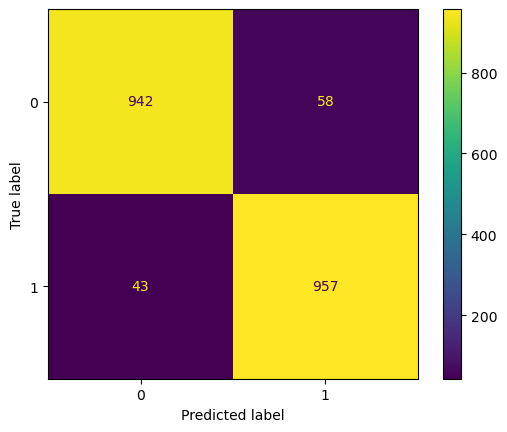

In [181]:
lr_pred = lr_model.predict(X_test)

print("accuracy: " + str(accuracy_score(y_test, lr_pred)))
print("precision: " + str(precision_score(y_test, lr_pred)))
print("recall: " + str(recall_score(y_test, lr_pred)))
print("f1-score: " + str(f1_score(y_test, lr_pred)))

cm = confusion_matrix(y_true = y_test, y_pred = lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

**Random Forest**

In [182]:
from sklearn.ensemble import RandomForestClassifier

In [183]:
rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train, y_train)

accuracy: 0.986
precision: 0.986
recall: 0.986
f1-score: 0.986


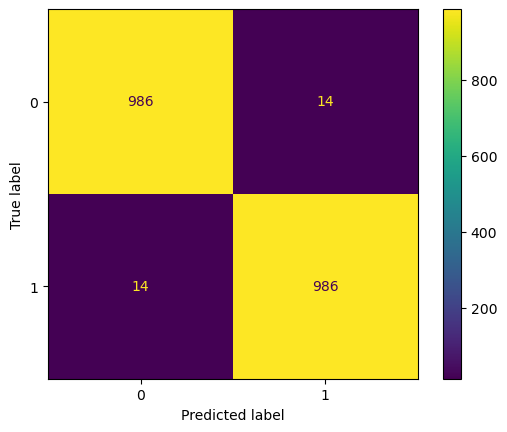

In [184]:
rfc_pred = rfc_model.predict(X_test)

print("accuracy: " + str(accuracy_score(y_test, rfc_pred)))
print("precision: " + str(precision_score(y_test, rfc_pred)))
print("recall: " + str(recall_score(y_test, rfc_pred)))
print("f1-score: " + str(f1_score(y_test, rfc_pred)))

cm = confusion_matrix(y_true = y_test, y_pred = rfc_pred)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()